## Tutorial04 Intro to machine learning/pattern recognition, Part II
* Here, instead of fitting a data set and then deciding which 'cloud' of training data is closer to each test vector, we'll just focus on drawing a boundary that maximizes the margin between points that are close to the dividing line (plane/hyperplane) that separates the two data sets.
* This is the approach implemented by Support Vector Machines (SVMs)
* Often effecient because you don't need to model the full data set - just need to maximize the margin
* Also does not rely on accurate estimation of the covariance matrix, which is problematic with small data sets (especially if you have fewer samples or trials than variables). 

[inspiration for this tutorial provided by this book](http://shop.oreilly.com/product/0636920034919.do)

## Import modules...add some sklearn functionality for the SVMs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Support vector classifier
from sklearn.svm import SVC 

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## The data generating function from the last tutorial...

In [3]:
# num_data_pnts = number of experimental trials
# mu0, mu1 = 2 element np.array that sets the mean of each variable in each condition
# cov0, cov1 = symetric 2 x 2 matrix with main diag specifying the variance of each variable 
# in each condition, and the off diag elements specifying the covariance

def gen_cor_data(num_data_pnts, mu0, mu1, cov0, cov1, plot):

    # number of variables, in this case lets keep it at 2 because that makes it easy to 
    # visualize
    V = 2

    # means of each variable in each condition
    mean_of_data0 = mu0; 
    mean_of_data1 = mu1 

    # generate some random data vectors drawn from normal
    data0 = np.random.randn(num_data_pnts,V) 
    data1 = np.random.randn(num_data_pnts,V) 

    # compute the eigenvalues and eigenvectors of the cov matrix
    evals0, evecs0 = eigh(cov0)
    evals1, evecs1 = eigh(cov1)

    # Construct c, so c*c^T = cov.
    c0 = np.dot(evecs0, np.diag(np.sqrt(evals0)))
    c1 = np.dot(evecs1, np.diag(np.sqrt(evals1)))

    # convert the data using by multiplying data by c
    # to be consistent with previous tutorials, we want the data running down columns...so do the double .T
    cdata0 = np.dot(c0, data0.T).T

    # then add in the mu offset...use np.ones * each condition mean
    cdata0 += np.hstack((np.ones((num_data_pnts,1))*mean_of_data0[0], np.ones((num_data_pnts,1))*mean_of_data0[1]))

    # repeat for the data from the second experimental condition 
    cdata1 = np.dot(c1, data1.T).T
    cdata1 += np.hstack((np.ones((num_data_pnts,1))*mean_of_data1[0], np.ones((num_data_pnts,1))*mean_of_data1[1])) 

    if plot:
        # plot the data...
        plt.scatter(cdata0[:,0], cdata0[:,1], color='b')
        plt.scatter(cdata1[:,0], cdata1[:,1], color='r')
        plt.xlabel('Resp Neuron 1', **fig_font)
        plt.ylabel('Resp Neuron 2', **fig_font)
        plt.legend(['Condition 1', 'Condition 2'])
        plt.show()
    
    return cdata0, cdata1

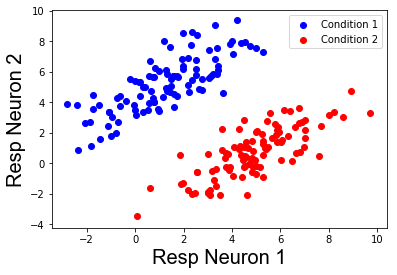

In [4]:
# generate data using our trusty function

np.random.seed(0)

# number of trials
N = 100

# means
mu0 = np.array([1,5])
mu1 = np.array([5,1])

# variance of each neuron
var_of_neuron0 = 3.2
var_of_neuron1 = 3.2

# covariance of neurons in each experimental condition 
cov_cond_0 = 2.5
cov_cond_1 = 2.5

cov0 = np.array([
        [var_of_neuron0, cov_cond_0],
        [cov_cond_0, var_of_neuron1]
    ])

cov1 = np.array([
        [var_of_neuron0, cov_cond_1],
        [cov_cond_1, var_of_neuron1]
    ])

# generate the data and plot...
d0, d1 = gen_cor_data(num_data_pnts=N, mu0=mu0, mu1=mu1, cov0=cov0, cov1=cov1, plot=1)

## Now think about drawing a decision boundary that will maximally separate these two classes (i.e. a boundary that will separate data from these two experimental conditions)
* In the case of 2D data like this, then we're looking to just draw a line that separates the two classes
* In higher dim data sets, then we're trying to find the plane (3D) or hyperplane (ND). 
* However, the logic is the same in all cases
* **Important**: Note that there are many lines that can perfectly separate these two classes!
* Given this, how do we select the optimal boundary? 

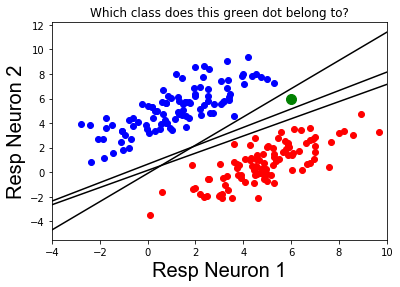

In [5]:
# define some lines that separate these two classes

# start with an x-axis that covers our space
x_range = -4,10
x_vals = np.linspace(x_range[0], x_range[1])

# plot data - note the abbreviated 'color' call
plt.scatter(d0[:, 0], d0[:, 1], c='b')
plt.scatter(d1[:, 0], d1[:, 1], c='r')
plt.xlabel('Resp Neuron 1', **fig_font)
plt.ylabel('Resp Neuron 2', **fig_font)

# draw some lines...y = ax+b...
for a, b in [(.75, 0.65), (.7, 0.15), (1.15, -.1)]:
    plt.plot(x_vals, a * x_vals + b, '-k')

plt.xlim(x_range[0], x_range[1])

# add an extra data point to make a point about 
plt.title('Which class does this green dot belong to?')
plt.plot(6, 6, 'o', c='g', markersize=10)
plt.show()

## Given the ambiguity here about where to draw the boundary, SVMs will instead create a line (or plane or hyperplane) with a margin that extends up to the nearest points in each data set.

(-4, 10)

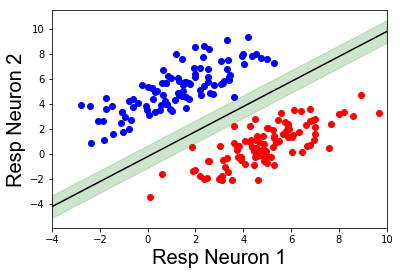

In [6]:
# an x-axis that covers our space
x_range = -4,10
x_vals = np.linspace(x_range[0], x_range[1])

# plot data - note the abbreviated 'color' call
plt.scatter(d0[:, 0], d0[:, 1], c='b')
plt.scatter(d1[:, 0], d1[:, 1], c='r')
plt.xlabel('Resp Neuron 1', **fig_font)
plt.ylabel('Resp Neuron 2', **fig_font)

# plot a sample line + margin that maximizes distance between boundary points.
# note the specification of a 3 element vector to loop over...cool feature.
for a, b, c in [(1, -.2, .9)]:
    y_vals = a * x_vals + b
    plt.plot(x_vals, y_vals, '-k')
    plt.fill_between(x_vals, y_vals + c, y_vals - c,
                     color='g', alpha=0.2)

plt.xlim(x_range[0], x_range[1])

## So above was just a hand-drawn version of what an SVM is trying to accomplish. Now we can actually implement to see how it works

In [7]:
# first lets assign parts of our data to train and test sets
# this is the same approach that we used for the distance based classifiers in the 
# first part of the tutorial.
percent_train_set = .9
r,c = d0.shape  # get the shape of our data sets
trn_length = int(np.round(percent_train_set*r, 0))

# now assign the first 90% of the trials to the training set...
# we'll stack up the first 90% from the first condition on top 
# of the 90% of data from the second condition
trn_data = np.vstack((d0[0:trn_length,:], d1[0:trn_length,:]))

# and the last 10% of the trials get stacked to make the test set...
tst_data = np.vstack((d0[trn_length:,:], d1[trn_length:,:]))

# last generate a vector that labels the data from each trial
# as belonging to condition 1 or condition 2
trn_labels = np.hstack((np.zeros(trn_length), np.ones(trn_length))).T
tst_labels = np.hstack((np.zeros(r-trn_length), np.ones(r-trn_length))).T

# The SVC was imported earlier via the sklearn module
# so we can train the classifer using our data.

# first specify the model...linear SVM with a large criterion value
# if C is big, that will enforce a hard margin...if C is small, it 
# will allow some leakage of points over the margin.
model = SVC(kernel='linear', C=1E10)

# then fit the model to our training data by passing in the data matrix + a list of labels that denotes the 
# experimental condition for each trial
model.fit(trn_data, trn_labels)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Now take a look at the model and how it separates the data.

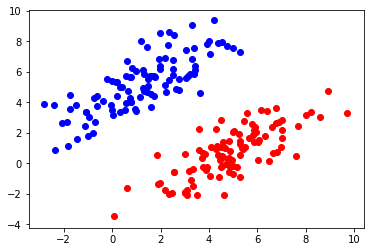

In [8]:
plt.scatter(d0[:, 0], d0[:, 1], color='b')
plt.scatter(d1[:, 0], d1[:, 1], color='r')

# grab a ui (handle) for the axis
# then get the x limits and the y limits (ranges)
axis = plt.gca()
x_limits = axis.get_xlim()
y_limits = axis.get_ylim()

# create grid to evaluate model
x = np.linspace(x_limits[0], x_limits[1], 100)
y = np.linspace(y_limits[0], y_limits[1], 100)
Y, X = np.meshgrid(y, x)

## Then eval the model over the span of the data

(-4.221454055917709, 10.023381776832679)

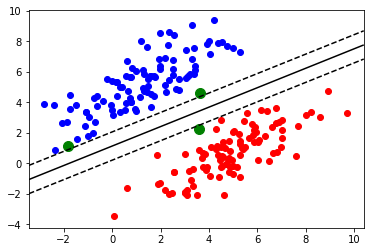

In [9]:
# stack up the data into a 10000,2 matrix
XY = np.vstack([X.ravel(), Y.ravel()]).T

# compute the decision function across all points 
# that span the space that the model is fitting
# take the decision function and reshape to the size of data
DF = model.decision_function(XY).reshape(X.shape)

# plot the data
plt.scatter(d0[:, 0], d0[:, 1], color='b')
plt.scatter(d1[:, 0], d1[:, 1], color='r')

# grab the handle for the axis
axis = plt.gca()

# plot the decision boundary and the margins on either side of boundary
axis.contour(X, Y, DF, colors='k',
           levels=[-.8, 0, .8],
           linestyles=['--', '-', '--'])

# plot support vectors as points in the figure
axis.scatter(model.support_vectors_[:, 0],
           model.support_vectors_[:, 1],
           s=100,c='g');

axis.set_xlim(x_limits)
axis.set_ylim(y_limits)

## The highlighted points are the 'support vectors' and are the points that define the fit of the boundary that best separates the data associated with each experimental condition. 
* You can think of these points as 'pivots' or leverage points that constrain the fit of the boundary
* Notice also that only the position of the support vectors matters here. The positions of the other points, so long as they are one side or the other of the margin, do not matter. 
* This stands in contrast the Maha distance classifer that modeled the entire distribution of data in each class...the SVM only cares about maximizing the margin along the boundary 

## See it in action...

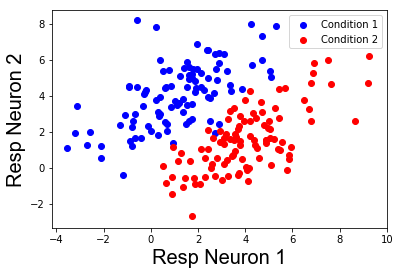

Classification accuracy with a SVM is:  0.95


In [10]:
# make data sets...then classify with an SVM
# for fun, make the same data set that we used with the Maha distance classifier
np.random.seed(2)
mu0 = np.array([1,4])
mu1 = np.array([4,1.5])

# variance of each neuron
var_of_neuron0 = 3
var_of_neuron1 = 3

# covariance of neurons in each experimental condition 
cov_cond_0 = 2
cov_cond_1 = 2

cov0 = np.array([
        [var_of_neuron0, cov_cond_0],
        [cov_cond_0, var_of_neuron1]
    ])

cov1 = np.array([
        [var_of_neuron0, cov_cond_1],
        [cov_cond_1, var_of_neuron1]
    ])

# generate the data and plot...
d0, d1 = gen_cor_data(num_data_pnts=N, mu0=mu0, mu1=mu1, cov0=cov0, cov1=cov1, plot=1)

# now lets generate a training set and a test set. We'll use 90% of our data as a training set
# and leave 10% as a test set
r,c = d0.shape  # get the shape of our data set (and d1 is the same size, so just need to get one of these)
trn_length = int(np.round(.9*r, 0))

# now assign the first 90% of the trials to the training set...
# we'll stack up the first 90% from the first condition on top 
# of the 90% of data from the second condition
trn_data = np.vstack((d0[0:trn_length,:], d1[0:trn_length,:]))

# and the last 10% of the trials to the test set...
tst_data = np.vstack((d0[trn_length:,:], d1[trn_length:,:]))

# last its helpful to generate a vector that labels the data from each trial
# as belonging to condition 1 or condition 2
trn_labels = np.hstack((np.zeros(trn_length), np.ones(trn_length))).T
tst_labels = np.hstack((np.zeros(r-trn_length), np.ones(r-trn_length))).T

# then train the model - Play with C a bit here...
model = SVC(kernel='linear', C=1)
model.fit(trn_data, trn_labels)

# then classify the test trials
class_labels = model.predict(tst_data)

# Then just compute our classification accuracy by comparing the predicted labels to the ground truth
class_acc = np.sum(class_labels==tst_labels) /  tst_data.shape[0]
print('Classification accuracy with a SVM is: ', class_acc)
#print(trn_labels)